In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from itertools import combinations
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

In [11]:
print(sys.path)

['/home/mikhail-xnor/Projects/GMDH/examples', '/home/mikhail-xnor/Projects/GMDH/build', 'C:/Users/Mi/Documents/Diploma/GMDH/build/Release', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/home/mikhail-xnor/Projects/GMDH/gmdhpy/lib/python3.10/site-packages']


In [2]:
sys.path.insert(1, "C:/Users/Mi/Documents/Diploma/GMDH/build/Release")
sys.path.insert(1, "/home/mikhail-xnor/Projects/GMDH/build")

In [3]:
import gmdhpy as gm

In [4]:
from gmdhpy import Criterion, CriterionType

In [15]:
dir(gm)

['COMBI',
 'Criterion',
 'CriterionType',
 'GMDH',
 'MIA',
 'MULTI',
 'ParallelCriterion',
 'PolynomialType',
 'SequentialCriterion',
 'Solver',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'convertToTimeSeries',
 'splitData',
 'splitted_data']

In [5]:
crit = Criterion(CriterionType.regularity)

In [5]:
def data_preparation(x, lags, validate_size, test_size=0):
    #print("x: ", x)
    x_data = list()
    y_data = list()
    for i in range(len(x) - lags):
        x_data.append(list(x.values[i:i+lags]))
        y_data.append(x.values[i+lags])
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validate_size, shuffle=False)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    #print("x_train:\n", x_train)
    #print("y_train:\n", y_train)
    #print("x_val:\n", x_val)
    #print("y_val:\n", y_val)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=False)
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_val, y_val

def print_polynom(polynom, coeffs):
    best_polynom_str = "y ="
    for i in range(len(polynom)):
        if coeffs[i] > 0:
            if i > 0:
                best_polynom_str += " + "
            else:
                best_polynom_str += " "
        else:
            best_polynom_str += " - "
        best_polynom_str += str(abs(coeffs[i]))
        if i != len(coeffs) - 1:
            best_polynom_str += "*x" + str(polynom[i] + 1)
    print(best_polynom_str)

In [6]:
def regression(x, lags, validate_size):
    x_train, y_train, x_val, y_val = data_preparation(x, lags, validate_size)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    coeffs = list(lr.coef_)
    coeffs.append(lr.intercept_)
    coeffs = [round(coeff, 6) for coeff in coeffs]
    y_pred = lr.predict(x_val)
    error = round(mean_squared_error(y_pred, y_val), 6)
    print_polynom(range(lags + 1), coeffs)
    return y_pred

In [29]:
LinearRegression?

In [7]:
def regression_combi(x, lags, validate_size, test_size):
    x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(x, lags, validate_size, test_size)
    lr = LinearRegression(n_jobs=-1)
    last_error = 100000000000000
    best_coeffs = []
    best_polynom = []
    for level in range(1, x_train.shape[1] + 1):
        errors = []
        for comb in combinations(range(x_train.shape[1]), level):
            lr.fit(x_train[:, comb], y_train)
            coeffs = list(lr.coef_)
            coeffs.append(lr.intercept_)
            coeffs = [round(coeff, 6) for coeff in coeffs]
            y_pred = lr.predict(x_test[:, comb])
            error = round(mean_squared_error(y_pred, y_test), 6)
            comb = list(comb)
            comb.append(lags)
            errors.append((error, coeffs, comb))
        errors.sort()
        #print(errors[0])
        if last_error > errors[0][0]:
            last_error = errors[0][0]
            best_coeffs = errors[0][1]
            best_polynom = errors[0][2]
        else:
            break
    best_polynom_str = "y ="
    print_polynom(best_polynom, best_coeffs)
    y_pred = lr.fit(x_train[:, best_polynom[:-1]], y_train).predict(x_val[:, best_polynom[:-1]])
    return y_pred

In [5]:
%%time
data = pd.read_csv("Sberbank.csv")['close'][:-50000]
lags = 10
test_size = 0.33
validate_size = 0.2

CPU times: user 160 ms, sys: 38.5 ms, total: 199 ms
Wall time: 204 ms


In [12]:
gm.COMBI.fit?

In [6]:
%%time
mat, vec = gm.convertToTimeSeries(data, lags)
splited_data = gm.splitData(mat, vec, validate_size, False, 0)

CPU times: user 143 ms, sys: 7.53 ms, total: 151 ms
Wall time: 148 ms


In [ ]:
%%time
combi = gm.COMBI()
combi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), test_size, 0, 0, 1, -10, 1);
print(combi.getBestPolymon())
y_pred_combi = combi.predict(splited_data.x_test)

LEVEL 1 (10 combinations) [===============>              ] 50% :00s] 

/home/mikhail-xnor/Projects/GMDH/gmdhpy/lib/python3.10/site-packages/IPython/core/magics/execution.py:1316: Warning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!

  exec(code, glob, local_ns)


LEVEL 1 (10 combinations) [==============================] 100% :00s] 
LEVEL 2 (45 combinations) [==============================] 100% :02s] 
LEVEL 3 (120 combinations) [==============>               ] 48% :04s] 

In [7]:
%%time
multi = gm.MULTI()
multi.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, test_size, 0, 0, 1, -10, 1);
print(multi.getBestPolymon())
y_pred_multi = multi.predict(splited_data.x_test)

LEVEL 1 (10 combinations) [============>                 ] 40% :00s] 

<timed exec>:2: Warning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!



LEVEL 1 (10 combinations) [==============================] 100% :00s] 
LEVEL 2 (35 combinations) [==============================] 100% :02s] ?25l
LEVEL 3 (30 combinations) [==============================] 100% :03s] ?25l
LEVEL 4 (28 combinations) [==============================] 100% :04s] ?25l
LEVEL 5 (24 combinations) [==============================] 100% :03s] ?25l
LEVEL 6 (20 combinations) [==============================] 100% :03s] ?25l


AttributeError: 'gmdhpy.MULTI' object has no attribute 'getBestPolymon'

In [19]:
try:
    y_pred_multi = multi.predict(np.delete(splited_data.x_test, -1, 1))
except Exception as err:
    print(err)

Input data number of cols is not match number of cols of fitted data!


array([[240.85, 240.89, 241.18, ..., 239.77, 240.2 , 240.4 ],
       [240.89, 241.18, 240.13, ..., 240.2 , 240.4 , 240.4 ],
       [241.18, 240.13, 239.69, ..., 240.4 , 240.4 , 240.01],
       ...,
       [242.79, 242.83, 243.11, ..., 242.25, 242.27, 242.2 ],
       [242.83, 243.11, 243.15, ..., 242.27, 242.2 , 242.43],
       [243.11, 243.15, 242.78, ..., 242.2 , 242.43, 242.2 ]])

In [10]:
splited_data.x_test

array([[240.85, 240.89, 241.18, ..., 240.2 , 240.4 , 240.4 ],
       [240.89, 241.18, 240.13, ..., 240.4 , 240.4 , 240.01],
       [241.18, 240.13, 239.69, ..., 240.4 , 240.01, 239.85],
       ...,
       [242.79, 242.83, 243.11, ..., 242.27, 242.2 , 242.43],
       [242.83, 243.11, 243.15, ..., 242.2 , 242.43, 242.2 ],
       [243.11, 243.15, 242.78, ..., 242.43, 242.2 , 242.  ]])

In [22]:
%%time
mia = gm.MIA()
mia.fit(splited_data.x_train, splited_data.y_train, gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 5, gm.PolynomialType.quadratic, test_size, 0, 0, 0, -2, 1);
print(mia.getBestPolymon())
y_pred_mia = mia.predict(splited_data.x_test)

<timed exec>:2: DeprecationWarning: 
Warning! The input number of threads is incorrect!
The default value is used (threads = 1)!

<timed exec>:2: DeprecationWarning: 
Warning! The input number of p is incorrect!
The default value is used (p = 1)!



LEVEL 1 (45 combinations) [==============================] 100% :00s]                                               
LEVEL 2 (10 combinations) [==============================] 100% :00s]                                               
y = - 0.010132*x4 + 1.009860*x10 - 0.003874*x4*x10 + 0.001968*x4^2 + 0.001907*x10^2 + 0.017167

CPU times: total: 578 ms
Wall time: 599 ms


In [33]:
%%time
y_pred_lr_combi = regression_combi(data, lags, validate_size, test_size)

y = - 0.015762*x6 + 0.011931*x7 + 0.022788*x9 + 0.980975*x10 + 0.014977
CPU times: total: 25.3 s
Wall time: 25.3 s


In [12]:
%time
y_pred_lr = regression(data, lags, validate_size)

CPU times: total: 0 ns
Wall time: 0 ns
y = 0.000482*x1 - 0.01001*x2 + 0.014102*x3 - 0.009262*x4 + 0.004287*x5 - 0.019176*x6 + 0.008529*x7 + 0.013416*x8 + 0.027205*x9 + 0.970369*x10 + 0.013856


In [13]:
#np.savetxt("Sber.csv", np.asarray(data.values), delimiter=",")

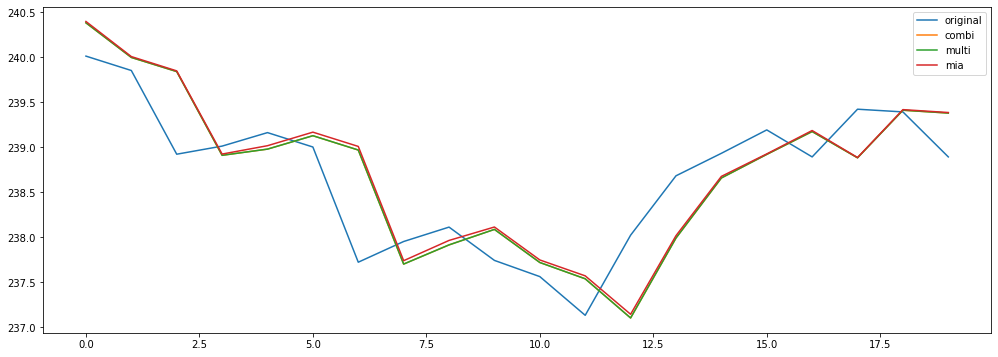

In [16]:
n = 20
plt.figure(figsize=(17, 6))
sns.lineplot(x=np.arange(n), y=splited_data.y_test[:n], label='original');
sns.lineplot(x=np.arange(n), y=y_pred_combi[:n], label='combi');
sns.lineplot(x=np.arange(n), y=y_pred_multi[:n], label='multi');
sns.lineplot(x=np.arange(n), y=y_pred_mia[:n], label='mia');
#sns.lineplot(x=np.arange(n), y=y_pred_lr_combi[:n], label='regr_combi');
#sns.lineplot(x=np.arange(n), y=y_pred_lr[:n], label='regr');

In [86]:
def stat(y_real, y_pred):
    print("right:", ((y_real * y_pred > 0)).sum())
    print("wrong:", ((y_real * y_pred < 0)).sum())
    print("zero:", ((y_real * y_pred == 0)).sum())

In [89]:
print()
stat(splited_data.y_test, y_pred_combi)

right: 10181
wrong: 9835
zero: 304


In [90]:
stat(splited_data.y_test, y_pred_multi)

right: 10181
wrong: 9835
zero: 304


In [91]:
stat(splited_data.y_test, y_pred_mia)

right: 10010
wrong: 10006
zero: 304
